In [1]:
import tensorflow as tf
from carrim import PhysicalModel, RIM
from carrim.models import CNN, Model
import os
import json
from argparse import Namespace
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

2022-07-07 10:46:47.508254: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-07 10:46:47.508297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fortytwo): /proc/driver/nvidia/version does not exist
2022-07-07 10:46:47.510074: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model = os.path.join("../models/CNN_g1_043_lr0.0001_dr0.9_inceptionV3_220429122436") # 1
# model = os.path.join("../models/CNN_g1_037_lr0.0001_dr1.0_perreault_levasseur2016_220429122436") # 2 ish
# model = os.path.join("../models/CNN_g1_093_lr0.0001_dr0.9_resnet50_220429180730") # best resnet



with open(model + "/cnn_model_hparams.json", "r") as f:
    hparams = json.load(f)
with open(model + "/script_params.json", "r") as f:
    args = json.load(f)
args = Namespace(**args)

cnn = CNN(**hparams)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=cnn)
checkpoint_manager = tf.train.CheckpointManager(ckpt, model, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

phys = PhysicalModel(
        pixels=args.pixels,
        image_fov=args.image_fov,
        src_fov=args.src_fov,
        psf_cutout_size=args.psf_cutout_size,
        r_ein_min=args.r_ein_min,
        r_ein_max=args.r_ein_max,
        n_min=args.n_min,
        n_max=args.n_max,
        r_eff_min=args.r_eff_min,
        r_eff_max=args.r_eff_max,
        max_gamma=args.max_gamma,
        max_ellipticity=args.max_ellipticity,
        max_lens_shift=args.max_lens_shift,
        max_source_shift=args.max_source_shift,
        noise_rms_min=args.noise_rms_min,
        noise_rms_max=args.noise_rms_max,
        noise_rms_mean=args.noise_rms_mean,
        noise_rms_std=args.noise_rms_std,
        psf_fwhm_min=args.psf_fwhm_min,
        psf_fwhm_max=args.psf_fwhm_max,
        psf_fwhm_std=args.psf_fwhm_std,
        psf_fwhm_mean=args.psf_fwhm_mean,
        sersic_i_eff=100
)

In [3]:
N = 10000
B = 10

true = []
pred = []

for batch in tqdm(range(N//B)):
    obs, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(B)
    true.append(params.numpy())
    pred.append(phys.model_to_physical(cnn(obs).numpy()))
true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)

  0%|                                                                                                                                                                                     | 0/1000 [00:00<?, ?it/s]2022-05-01 08:15:54.616222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22141440 exceeds 10% of free system memory.
2022-05-01 08:15:54.623706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22141440 exceeds 10% of free system memory.
2022-05-01 08:15:54.632298: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22141440 exceeds 10% of free system memory.
2022-05-01 08:15:54.806186: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:06<00:00,  4.05it/s]


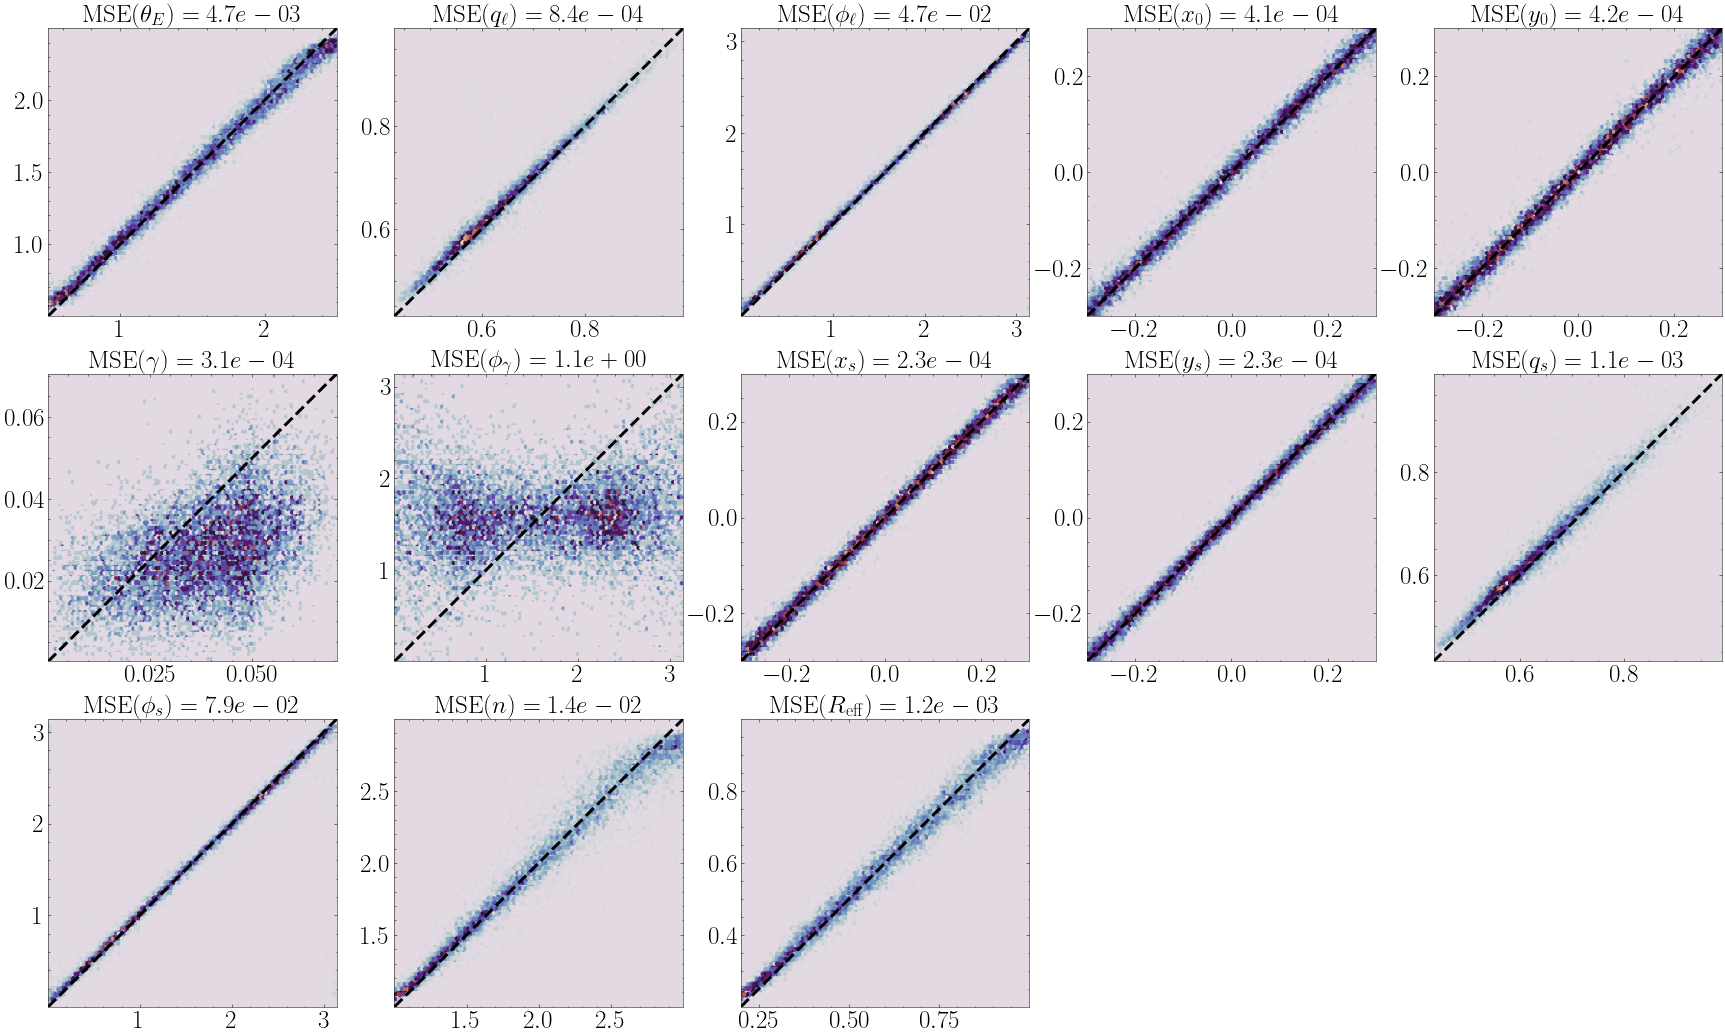

In [11]:
titles = [r"$\theta_E$", r"$q_\ell$", r"$\phi_\ell$", r"$x_0$", r"$y_0$", r"$\gamma$", r"$\phi_\gamma$", r"$x_s$", r"$y_s$", r"$q_s$", r"$\phi_s$", r"$n$", r"$R_{\mathrm{eff}}$"]
titles2 = [r"\theta_E", r"q_\ell", r"\phi_\ell", r"x_0", r"y_0", r"\gamma", r"\phi_\gamma", r"x_s", r"y_s", r"q_s", r"\phi_s", r"n", r"R_{\mathrm{eff}}"]

fig, axs = plt.subplots(3, 5, figsize=(30, 18))

for i in range(3):
    for j in range(5):
        k = 5 * i + j
        if k < 13:
#             axs[i, j].plot(true[:, k], pred[:, k], "b.", alpha=0.5)
            x_max = true[:, k].max()
            x_min = true[:, k].min()
            axs[i, j].hexbin(true[:, k], pred[:, k], cmap="twilight", extent=[x_min, x_max]*2)
            axs[i, j].plot((x_min, x_max), (x_min, x_max), "k--", lw=3)
            axs[i, j].set_title(r"$\mathrm{MSE}(%s) = %.1e$" % (titles2[k], np.mean((true[:, k] - pred[:, k])**2)))
            axs[i, j].set_xlim(x_min, x_max)
            axs[i, j].set_ylim(x_min, x_max)
        if k >= 13:
            axs[i, j].axis("off")

In [5]:
# model = os.path.join("../models/RIMA_g1_042_TS4_U64_Atanh_lr0.0001_dr0.8_resnet50_220430092849") # need to redownload this one
model = os.path.join("../models/RIMA_g1_100_TS4_U16_Aelu_lr0.0001_dr0.9_inceptionV3_220430102638") # 1
# model = os.path.join("../models/RIMA_g1_088_TS4_U32_Atanh_lr0.0001_dr0.9_perreault_levasseur2016_220430102004") # 2?



with open(model + "/cnn_model_hparams.json", "r") as f:
    cnn_hparams = json.load(f)
with open(model + "/model_hparams.json", "r") as f:
    mlp_hparams = json.load(f)
with open(model + "/script_params.json", "r") as f:
    args = json.load(f)
args = Namespace(**args)

cnn_model = CNN(**cnn_hparams)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=cnn_model)
checkpoint_manager = tf.train.CheckpointManager(ckpt, os.path.join(model, "cnn"), max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

mlp = Model(**mlp_hparams)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=mlp)
checkpoint_manager = tf.train.CheckpointManager(ckpt, os.path.join(model, "rim"), max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

phys = PhysicalModel(
        pixels=args.pixels,
        image_fov=args.image_fov,
        src_fov=args.src_fov,
        psf_cutout_size=args.psf_cutout_size,
        r_ein_min=args.r_ein_min,
        r_ein_max=args.r_ein_max,
        n_min=args.n_min,
        n_max=args.n_max,
        r_eff_min=args.r_eff_min,
        r_eff_max=args.r_eff_max,
        max_gamma=args.max_gamma,
        max_ellipticity=args.max_ellipticity,
        max_lens_shift=args.max_lens_shift,
        max_source_shift=args.max_source_shift,
        noise_rms_min=args.noise_rms_min,
        noise_rms_max=args.noise_rms_max,
        noise_rms_mean=args.noise_rms_mean,
        noise_rms_std=args.noise_rms_std,
        psf_fwhm_min=args.psf_fwhm_min,
        psf_fwhm_max=args.psf_fwhm_max,
        psf_fwhm_std=args.psf_fwhm_std,
        psf_fwhm_mean=args.psf_fwhm_mean,
        sersic_i_eff=100
)

rim = RIM(
    physical_model=phys,
    model=mlp,
    cnn_model=cnn_model,
    steps=args.steps,
    adam=args.adam,
)


In [8]:
N = 5000
B = 10

true_rim = []
pred_rim = []
chisq = []

for batch in tqdm(range(N//B)):
    obs, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(B)
    y_series, chi_squared = rim(obs, noise_rms, psf_fwhm)
    true_rim.append(params.numpy())
    pred_rim.append(phys.model_to_physical(y_series))
    chisq.append(chi_squared)
true_rim = np.concatenate(true_rim, axis=0)
pred_rim = np.concatenate(pred_rim, axis=1)
chisq = np.concatenate(chisq, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:49<00:00,  1.30s/it]


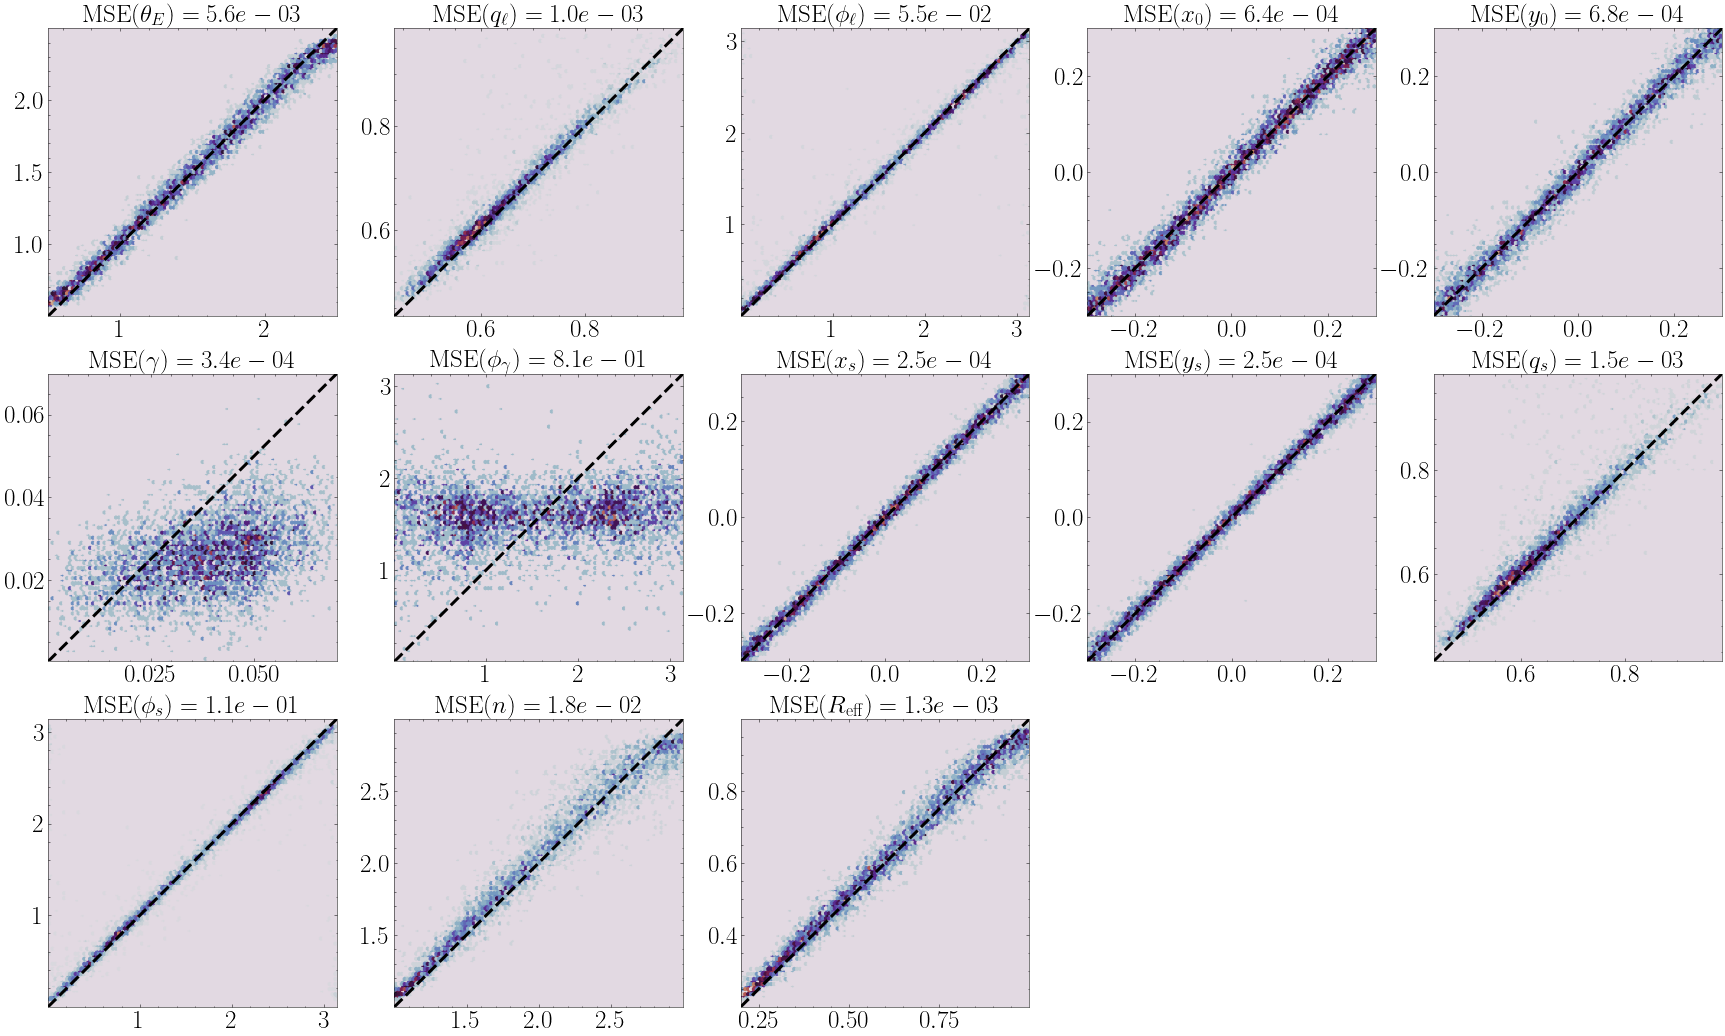

In [11]:
titles = [r"$\theta_E$", r"$q_\ell$", r"$\phi_\ell$", r"$x_0$", r"$y_0$", r"$\gamma$", r"$\phi_\gamma$", r"$x_s$", r"$y_s$", r"$q_s$", r"$\phi_s$", r"$n$", r"$R_{\mathrm{eff}}$"]
titles2 = [r"\theta_E", r"q_\ell", r"\phi_\ell", r"x_0", r"y_0", r"\gamma", r"\phi_\gamma", r"x_s", r"y_s", r"q_s", r"\phi_s", r"n", r"R_{\mathrm{eff}}"]

step = 1
fig, axs = plt.subplots(3, 5, figsize=(30, 18))
for i in range(3):
    for j in range(5):
        k = 5 * i + j
        if k < 13:
#             axs[i, j].plot(true_rim[:, k], pred_rim[step, :, k], "b.", alpha=0.5)
            x_max = true_rim[:, k].max()
            x_min = true_rim[:, k].min()
            axs[i, j].hexbin(true_rim[:, k], pred_rim[step, :, k], cmap="twilight", extent=[x_min, x_max]*2)
            axs[i, j].plot((x_min, x_max), (x_min, x_max), "k--", lw=3)
            axs[i, j].set_title(r"$\mathrm{MSE}(%s) = %.1e$" % (titles2[k], np.mean((true_rim[:, k] - pred_rim[step, :, k])**2)))
            axs[i, j].set_xlim(x_min, x_max)
            axs[i, j].set_ylim(x_min, x_max)
        if k >= 13:
            axs[i, j].axis("off")